## Import modules

In [1]:
# fundamentals
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.feature_selection import SelectPercentile

# pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# Evaluation, optimization, metrics
from sklearn.metrics import recall_score, precision_score, precision_recall_curve, f1_score, roc_auc_score, roc_curve, auc, make_scorer
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.inspection import permutation_importance

# model
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

## Prepare graphics

In [2]:
def plot_roc(pipe, Xtest, ytest):
    yscores = pipe.predict_proba(Xtest)[:,1]
    fpr, tpr, _ = roc_curve(ytest, yscores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')

## Load, clean and split the data

In [3]:
raw_data = pd.read_csv("Data/HR_Analytics.csv")

In [4]:
# Assign columns to column groups
catcols = ["AgeGroup", "SalarySlab", "Department", "EducationField", "JobRole", "MaritalStatus"]
numcols = ["Education", "EnvironmentSatisfaction", "BusinessTravel", "JobInvolvement", "JobLevel", "JobSatisfaction", "PerformanceRating", 
           "RelationshipSatisfaction", "StockOptionLevel", "WorkLifeBalance", "OverTime", "Gender", "Age", "DailyRate", "DistanceFromHome", 
           "HourlyRate", "MonthlyIncome", "MonthlyRate", "NumCompaniesWorked", "PercentSalaryHike", "TotalWorkingYears", 
           "TrainingTimesLastYear", "YearsAtCompany", "YearsInCurrentRole", "YearsSinceLastPromotion", "YearsWithCurrManager"]
delcols = ["EmpID", "EmployeeCount", "EmployeeNumber", "StandardHours", "Over18"]

# clean data
def clean_data(DF, delcols=delcols):
    df = DF.drop_duplicates()
    df = df.drop(delcols, axis=1)
    df = df.replace({"Yes": 1,
                     "No": 0,
                     "Female": 1,
                     "Male": 0,
                     "Non-Travel": 0,
                     "TravelRarely": 1,
                     "Travel_Rarely": 1,
                     "Travel_Frequently": 2})
    #df = df.dropna(axis=0)
    return df

data = clean_data(raw_data)

Xtrain, Xtest, ytrain, ytest = train_test_split(data.drop("Attrition", axis=1), 
                                                data["Attrition"], 
                                                test_size=0.2, 
                                                shuffle=True,
                                                stratify=data["Attrition"], 
                                                random_state=42)

## Prepare preprocessing

In [5]:
encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
knnimp = KNNImputer(add_indicator=True)
simpimp = SimpleImputer(strategy="median")
std = StandardScaler()

imputer = simpimp

catpipe = make_pipeline(encoder)
numpipe = Pipeline([("imputer", simpimp),
                    ("scaler", std)])

coltrans = ColumnTransformer(transformers=[("encoder", encoder, catcols),
                                           ("numpipe", numpipe, numcols)])
selection = SelectPercentile(percentile=90) # percentile=10

## Initialize models, pipelines and VotingClassifier

In [6]:
svc = SVC(C=1,
          kernel="poly",
          degree=3,
          gamma="auto",
          class_weight="balanced",
          cache_size=1000, 
          probability=True,
          random_state=42)
pipe_svc = Pipeline([("prepper", coltrans),
                     ("selector", selection),
                     ("estimator", svc)])
#pipe_svc.fit(Xtrain, ytrain)

log = LogisticRegression(class_weight="balanced", 
                         penalty='l2', 
                         C=0.05, 
                         solver='lbfgs', 
                         intercept_scaling=1, 
                         max_iter=10000, 
                         verbose=0, 
                         random_state=42)
pipe_log = Pipeline([("prepper", coltrans),
                     ("estimator", log)])
#pipe_log.fit(Xtrain, ytrain)

rfc = RandomForestClassifier(class_weight="balanced", 
                             n_estimators=60, 
                             max_depth=10, 
                             min_samples_leaf=8, 
                             random_state=42)
pipe_rfc = Pipeline([("prepper", coltrans),
                     ("estimator", rfc)])
#pipe_rfc.fit(Xtrain, ytrain)

vc = VotingClassifier(estimators=
                      [("SVC", pipe_svc), 
                       ("Log", pipe_log), 
                       ("RFC", pipe_rfc)],
                       voting='soft')#,
                      #weights=None)

## Set search space

In [7]:
def weights():
    weights = []
    for a in range(4):
        for b in range(4):
            for c in range(4):
                independent = True
                if [a,b,c] == [0,0,0]:
                    independent = False
                for n in [2, 3]:
                    for weight in weights:
                        if [a,b,c] == [n*weight[0], n*weight[1], n*weight[2]]:
                            independent = False
                            break
                if independent:
                    weights.append([a,b,c])
    return weights

search_space = {"weights": weights()}

## Finish pipeline and run grid search

{'weights': [2, 3, 2]}
Best F1 score: 58.52%
--------------------------------------------------------
F1 score on test set:	64.08%
Recall on test set:	70.21%
Precision on test set:	58.93%


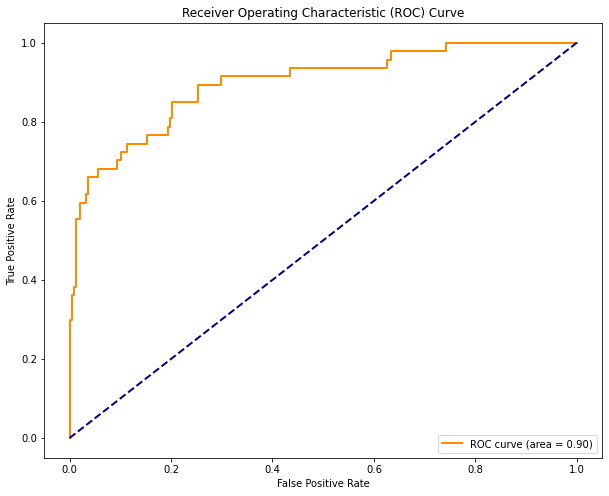

In [8]:
grid_vc = GridSearchCV(estimator=vc,
                        param_grid=search_space,
                        scoring="f1",
                        cv=4,
                        n_jobs=-1)
grid_vc.fit(Xtrain, ytrain)
#model_svc = pipe_svc.best_estimator_
#print(grid_svc.best_estimator_)
print(grid_vc.best_params_)
print(f"Best F1 score: {grid_vc.best_score_.mean():.2%}")
print("--------------------------------------------------------")
ypred = grid_vc.predict(Xtest)
print(f"F1 score on test set:\t{f1_score(ytest, ypred):.2%}")
print(f"Recall on test set:\t{recall_score(ytest, ypred):.2%}")
print(f"Precision on test set:\t{precision_score(ytest, ypred):.2%}")
plot_roc(grid_vc, Xtest, ytest)

In [9]:
results = pd.DataFrame(grid_vc.cv_results_).sort_values(by="mean_test_score", ascending=False).head(9)
results.iloc[:,4:]

,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
35,"[2, 3, 2]","{'weights': [2, 3, 2]}",0.585859,0.635294,0.595745,0.523810,0.585177,0.039968,1
34,"[2, 3, 1]","{'weights': [2, 3, 1]}",0.574257,0.613636,0.612245,0.534884,0.583756,0.032339,2
33,"[2, 3, 0]","{'weights': [2, 3, 0]}",0.557692,0.577778,0.600000,0.549451,0.571230,0.019546,3
36,"[2, 3, 3]","{'weights': [2, 3, 3]}",0.562500,0.588235,0.602151,0.523810,0.569174,0.029805,4
48,"[3, 3, 2]","{'weights': [3, 3, 2]}",0.571429,0.567901,0.620690,0.500000,0.565005,0.042942,5
24,"[1, 3, 3]","{'weights': [1, 3, 3]}",0.571429,0.589474,0.582524,0.515464,0.564723,0.029159,6
19,"[1, 2, 2]","{'weights': [1, 2, 2]}",0.568627,0.606742,0.577320,0.505495,0.564546,0.036903,7
18,"[1, 2, 1]","{'weights': [1, 2, 1]}",0.557692,0.600000,0.588235,0.505495,0.562856,0.036540,8
20,"[1, 2, 3]","{'weights': [1, 2, 3]}",0.556701,0.597701,0.568421,0.527473,0.562574,0.025173,9


[Text(0.5, 1.0, 'Features sorted by permutation importance'),
 Text(0.5, 0, 'Permutation Importance')]

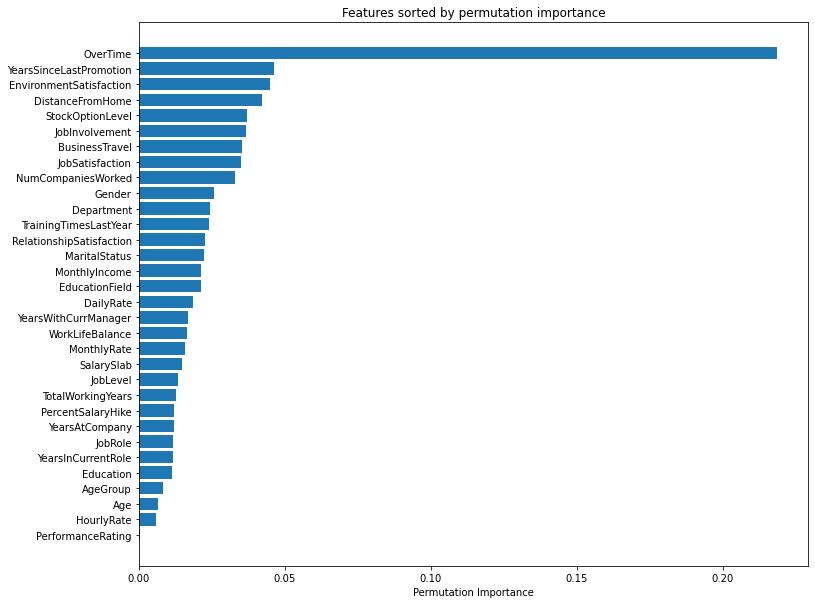

In [10]:
# Estimate feature importance through permutation importance
result = permutation_importance(grid_vc, Xtrain, ytrain, n_repeats=50, random_state=42)
importance_scores = abs(result.importances_mean)
#pipe_rfc = pipe_rfc.fit(features_train, target_train)
original_columns = Xtrain.columns
feature_importance_list = list(zip(original_columns, importance_scores))
sorted_feature_importance = sorted(feature_importance_list, key=lambda x: x[1], reverse=False)
orig_sorted_features, orig_sorted_importance = zip(*sorted_feature_importance)

# Plot it
fig, ax = plt.subplots(figsize=(12,10))
ax.barh(orig_sorted_features, orig_sorted_importance)
ax.set(title="Features sorted by permutation importance",
      xlabel="Permutation Importance")